## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
from tqdm.notebook import tqdm

## MNIST dataset

## Prepare data

In [2]:
from torchvision import datasets, transforms

mnist_train = datasets.MNIST(root="./datasets", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root="./datasets", train=False, transform=transforms.ToTensor(), download=True)

In [3]:
print(f"Number of MNIST training examples: {len(mnist_train)}")
print(f"Number of MNIST test examples: {len(mnist_test)}")

Number of MNIST training examples: 60000
Number of MNIST test examples: 10000


### Example image

Default image shape: torch.Size([1, 28, 28])
Reshaped image shape: torch.Size([28, 28])
The label for this image: 4


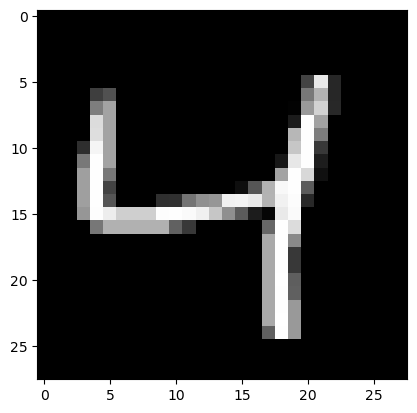

In [4]:
# Pick out an image and it's label from the training set
image, label = mnist_train[2]

# Plotting the image. Here the 1 in the 0th dimension means the image has only 1 color component
print("Default image shape: {}".format(image.shape))
# Get rid of the zeroth dimension to visualize the image with imshow
image = image.reshape([28,28])
print("Reshaped image shape: {}".format(image.shape))
plt.imshow(image, cmap="gray")

# Print the label
print("The label for this image: {}".format(label));

It is convenient to use a DataLoader that takes care of batching and shuffling

In [5]:
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

Example of a minibatch drawn from DataLoader:

In [6]:
data_train_iter = iter(train_loader)
images, labels = next(data_train_iter)

print("Shape of the minibatch of images: {}".format(images.shape))
print("Shape of the minibatch of labels: {}".format(labels.shape))
# print(data_train_iter.next())

Shape of the minibatch of images: torch.Size([100, 1, 28, 28])
Shape of the minibatch of labels: torch.Size([100])


## Logistic Regression Model

In [7]:
x = images.view(-1, 28*28)#flatten and divide into 28*28 elements
print("The shape of input x: {}".format(x.shape))

The shape of input x: torch.Size([100, 784])


In [8]:
# Inittialize parameters
W = torch.randn(784,10)/np.sqrt(784)
W.requires_grad_()
b = torch.zeros(10, requires_grad=True)

In [9]:
# Optimizer
optimizer = torch.optim.SGD([W,b], lr = 0.1)

In [10]:
# training
for images, labels in tqdm(train_loader):
    # zero out the gradients
    optimizer.zero_grad()
    
    # Forward pass
    x = images.view(-1, 28*28)
    y = torch.matmul(x,W) + b
    cross_entropy = F.cross_entropy(y, labels)
    
    # Backward pass
    cross_entropy.backward()
    optimizer.step()

  0%|          | 0/600 [00:00<?, ?it/s]

In [17]:
## Testing
correct = 0
total = len(mnist_test)

with torch.no_grad():
    # Iterate through test set minibatchs 
    for images, labels in tqdm(test_loader):
        # Forward pass
        x = images.view(-1, 28*28)
        y = torch.matmul(x, W) + b
        
        predictions = torch.argmax(y, dim=1)
        correct += torch.sum((predictions == labels).float())
    
print('Test accuracy: {}'.format(correct/total))

  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy: 0.9028000235557556


### LR using nn.module

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

In [3]:
# model building and training
# define LR model
class MNIST_Logistic_Regression(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784,10)
        
    def forward(self, x):
        return self.lin(x)

# load data
mnist_train = datasets.MNIST(root="./datasets", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root="./datasets", train=False, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

# Training
# Instantiate model
model = MNIST_Logistic_Regression()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr =0.1)

In [4]:
# Iterate through training data minibatches
for images, labels in tqdm(train_loader):
    # zero out the gradients
    optimizer.zero_grad()
    
    # Forward pass
    x = images.view(-1, 28*28)
    y = model(x)
    loss = criterion(y, labels)
    
    # Backward pass
    loss.backward()
    optimizer.step()

  0%|          | 0/600 [00:00<?, ?it/s]

In [5]:
# Testing
correcrt = 0
total = len(mnist_test)

# Iterate through test set minibatches
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        x = images.view(-1, 28*28)
        y = model(x)
        
        predictions = torch.argmax(y, dim=1)
        correcrt += torch.sum(predictions == labels)
print(f"Test accuracy:{correcrt.float()/total}")

  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy:0.902400016784668


## Multilayer perceptron

Next, we will use a 2-layer MLP for MNIST digit classification. The components of our model are as follows:
<br>
- Images (784 dimensions)
<br>
- First (input) layer (784x500 dimensions) -> Nonlinearity (ReLU)
<br>
- Second layer (500x10 dimensions) 
<br>
- Fully connected 10 hidden units -> softmax (Note: torch.nn.CrossEntropyLoss() combines softmax and cross-entropy. So we don't need to implement it explicitly.)


In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

In [7]:
# model building and training
# define LR model
class MNIST_MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 500)
        self.fc2 = nn.Linear(500, 10)
        
    def forward(self, x):
        # first layer with ReLU
        x = F.relu(self.fc1(x))
        
        # second layer
        return self.fc2(x)

# load data
mnist_train = datasets.MNIST(root="./datasets", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root="./datasets", train=False, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

# Training
# Instantiate model
model = MNIST_MLP()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr =0.1)

In [8]:
# Iterate through training data minibatches
for images, labels in tqdm(train_loader):
    # zero out the gradients
    optimizer.zero_grad()
    
    # Forward pass
    x = images.view(-1, 28*28)
    y = model(x)
    loss = criterion(y, labels)
    
    # Backward pass
    loss.backward()
    optimizer.step()

  0%|          | 0/600 [00:00<?, ?it/s]

In [9]:
# Testing
correcrt = 0
total = len(mnist_test)

# Iterate through test set minibatches
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        x = images.view(-1, 28*28)
        y = model(x)
        
        predictions = torch.argmax(y, dim=1)
        correcrt += torch.sum(predictions == labels)
print(f"Test accuracy:{correcrt.float()/total}")

  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy:0.9200999736785889


We see an improvement in test accuracy from 0.90 for LR model to 0.92 for the MLP model.